<a href="https://colab.research.google.com/github/yevonnaelandrew/galaxy-classification-ensemble/blob/main/All_Color_Space_VGG19_Non_trainable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue May 10 09:00:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
1.9593645740000056
GPU (s):
0.051608775999994805
GPU speedup over CPU: 37x


In [ ]:
from google.colab import drive
import os
import glob
import pandas as pd

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/galaxy-images/img_RGB.zip /content/img_RGB.zip

In [ ]:
!unzip /content/img_RGB.zip

Streaming output truncated to the last 5000 lines.
  inflating: content/img_RGB/spiral/598869.jpg  
  inflating: content/img_RGB/spiral/111799.jpg  
  inflating: content/img_RGB/spiral/780317.jpg  
  inflating: content/img_RGB/spiral/910544.jpg  
  inflating: content/img_RGB/spiral/834411.jpg  
  inflating: content/img_RGB/spiral/733208.jpg  
  inflating: content/img_RGB/spiral/886610.jpg  
  inflating: content/img_RGB/spiral/911110.jpg  
  inflating: content/img_RGB/spiral/708993.jpg  
  inflating: content/img_RGB/spiral/412282.jpg  
  inflating: content/img_RGB/spiral/329964.jpg  
  inflating: content/img_RGB/spiral/550580.jpg  
  inflating: content/img_RGB/spiral/481037.jpg  
  inflating: content/img_RGB/spiral/981685.jpg  
  inflating: content/img_RGB/spiral/213331.jpg  
  inflating: content/img_RGB/spiral/545684.jpg  
  inflating: content/img_RGB/spiral/979242.jpg  
  inflating: content/img_RGB/spiral/791017.jpg  
  inflating: content/img_RGB/spiral/797954.jpg  
  inflating: conte

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import pathlib
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
!pip install tensorflow-io
import tensorflow_io as tfio

     |████████████████████████████████| 23.4 MB 170 kB/s 


In [ ]:
def train_model(convert_color, original=False, preprocess=False):

  data_dir = pathlib.Path('/content/content/img_RGB')

  batch_size = 64
  img_height = 128
  img_width = 128

  IMG_SHAPE = (img_height, img_width) + (3,)

  train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  class_names = train_ds.class_names

  AUTOTUNE = tf.data.AUTOTUNE
  num_classes = len(class_names)

  train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

  data_augmentation = Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
  ])

  # Create the base model from the pre-trained model
  base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  
  base_model.trainable = False

  inputs = tf.keras.Input(shape=(128, 128, 3))
  x = data_augmentation(inputs)

  if original == True:
    print("Using the original RGB and preprocessing")
    x = tf.keras.applications.vgg19.preprocess_input(x)
  elif original == False:
    x = tf.keras.layers.Rescaling(scale=1./255)(x)
    x = convert_color(x)
    print("Using the converted colors")

  if preprocess == True:
    x = tf.keras.applications.vgg19.preprocess_input(x)
    print("Using preprocessing")

  x = base_model(x)
  x = tf.keras.layers.MaxPooling2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  outputs = tf.keras.layers.Dense(5)(x)
  model = tf.keras.Model(inputs, outputs)

  base_learning_rate = 0.0005

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  epochs=75
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
  )

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(16, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
80150528/80134624 [==============================] - 1s 0us/step
Using the original RGB and preprocessing
Epoch 1/75
360/360 [==============================] - 44s 79ms/step - loss: 1.0419 - accuracy: 0.6466 - val_loss: 0.6355 - val_accuracy: 0.7084
Epoch 2/75
360/360 [==============================] - 27s 74ms/step - loss: 0.6488 - accuracy: 0.7175 - val_loss: 0.5496 - val_accuracy: 0.7607
Epoch 3/75
360/360 [==============================] - 27s 74ms/step - loss: 0.6131 - accuracy: 0.7295 - val_loss: 0.5390 - val_accuracy: 0.7732
Epoch 4/75
360/360 [==============================] - 27s 74ms/step - loss: 0.5876 - accuracy: 0.7432 - val_loss: 0.5384 - val_accuracy: 0.7756
Epoch 5/75
360/360 [==============================] - 27s 74ms/step - loss: 0.5770 - accuracy: 0.7501 - val_loss: 0.5384 - val_accuracy: 0.7588
Epoch 6/75
360/360 [=====

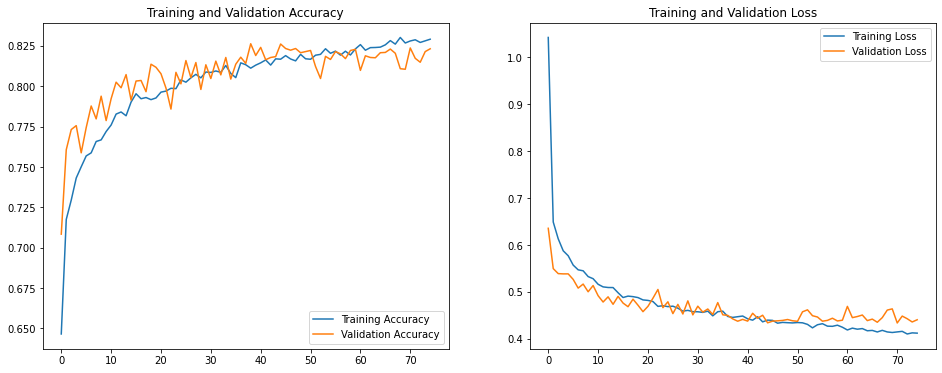

In [ ]:
train_model(None, original=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/75
360/360 [==============================] - 38s 79ms/step - loss: 0.9545 - accuracy: 0.6353 - val_loss: 0.6241 - val_accuracy: 0.7345
Epoch 2/75
360/360 [==============================] - 28s 76ms/step - loss: 0.6796 - accuracy: 0.7019 - val_loss: 0.5892 - val_accuracy: 0.7484
Epoch 3/75
360/360 [==============================] - 28s 77ms/step - loss: 0.6421 - accuracy: 0.7238 - val_loss: 0.5724 - val_accuracy: 0.7607
Epoch 4/75
360/360 [==============================] - 28s 77ms/step - loss: 0.6325 - accuracy: 0.7275 - val_loss: 0.5436 - val_accuracy: 0.7737
Epoch 5/75
360/360 [==============================] - 28s 77ms/step - loss: 0.6072 - accuracy: 0.7366 - val_loss: 0.5432 - val_accuracy: 0.7735
Epoch 6/75
360/360 [==============================] - 28s 77ms/step - loss: 0.5960 -

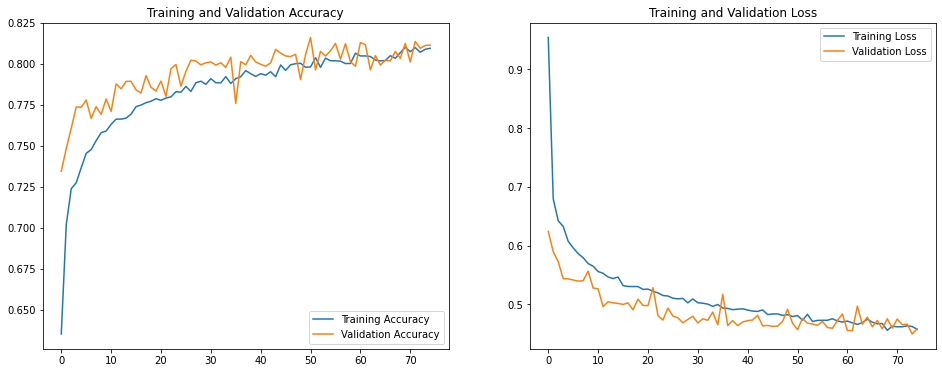

In [ ]:
train_model(tfio.experimental.color.rgb_to_lab, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/75
360/360 [==============================] - 38s 79ms/step - loss: 0.8894 - accuracy: 0.6292 - val_loss: 0.7252 - val_accuracy: 0.6759
Epoch 2/75
360/360 [==============================] - 28s 77ms/step - loss: 0.7349 - accuracy: 0.6839 - val_loss: 0.6966 - val_accuracy: 0.6837
Epoch 3/75
360/360 [==============================] - 28s 77ms/step - loss: 0.6952 - accuracy: 0.7048 - val_loss: 0.6616 - val_accuracy: 0.7081
Epoch 4/75
360/360 [==============================] - 28s 77ms/step - loss: 0.6732 - accuracy: 0.7155 - val_loss: 0.6335 - val_accuracy: 0.7230
Epoch 5/75
360/360 [==============================] - 28s 77ms/step - loss: 0.6516 - accuracy: 0.7232 - val_loss: 0.6114 - val_accuracy: 0.7362
Epoch 6/75
360/360 [==============================] - 28s 77ms/step - loss: 0.6395 - accuracy: 0.7327 - 

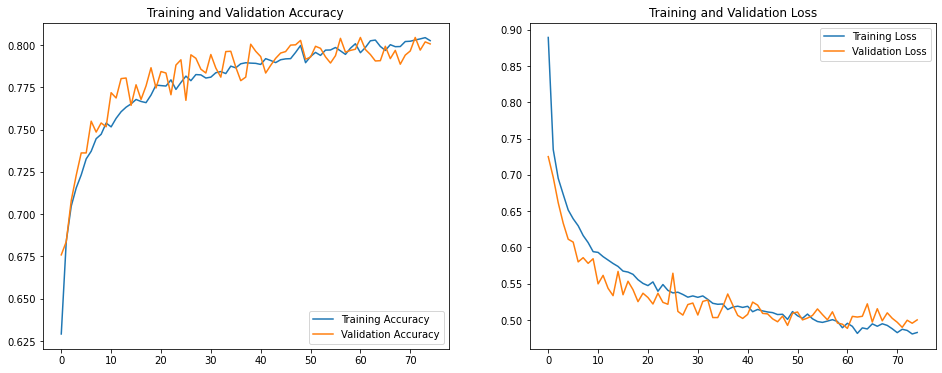

In [ ]:
train_model(tfio.experimental.color.rgb_to_lab, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/75
360/360 [==============================] - 37s 78ms/step - loss: 1.6186 - accuracy: 0.2744 - val_loss: 1.4248 - val_accuracy: 0.2860
Epoch 2/75
360/360 [==============================] - 28s 76ms/step - loss: 1.4313 - accuracy: 0.2874 - val_loss: 1.4145 - val_accuracy: 0.2860
Epoch 3/75
360/360 [==============================] - 28s 76ms/step - loss: 1.4264 - accuracy: 0.2914 - val_loss: 1.4144 - val_accuracy: 0.2860
Epoch 4/75
360/360 [==============================] - 28s 76ms/step - loss: 1.4253 - accuracy: 0.2913 - val_loss: 1.4194 - val_accuracy: 0.2860
Epoch 5/75
360/360 [==============================] - 27s 76ms/step - loss: 1.4245 - accuracy: 0.2892 - val_loss: 1.4164 - val_accuracy: 0.2890
Epoch 6/75
360/360 [==============================] - 27s 76ms/step - loss: 1.4240 -

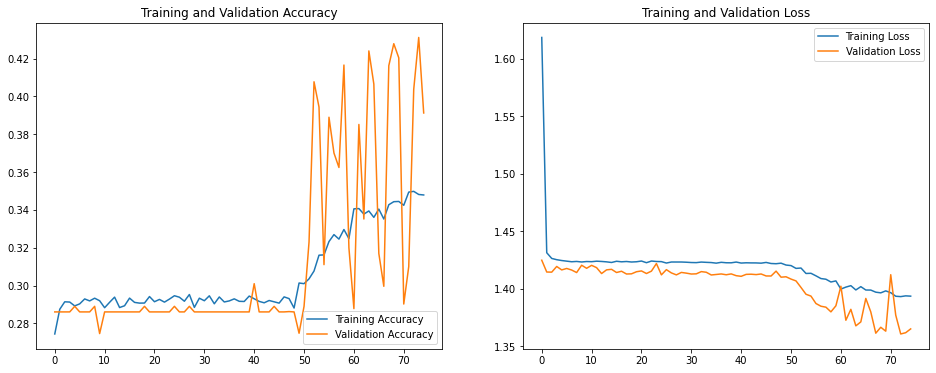

In [ ]:
train_model(tfio.experimental.color.rgb_to_xyz, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/75
360/360 [==============================] - 37s 78ms/step - loss: 1.1936 - accuracy: 0.4804 - val_loss: 0.9935 - val_accuracy: 0.5738
Epoch 2/75
360/360 [==============================] - 27s 75ms/step - loss: 1.0226 - accuracy: 0.5646 - val_loss: 0.9219 - val_accuracy: 0.6122
Epoch 3/75
360/360 [==============================] - 27s 75ms/step - loss: 0.9786 - accuracy: 0.5769 - val_loss: 0.8998 - val_accuracy: 0.6077
Epoch 4/75
360/360 [==============================] - 27s 75ms/step - loss: 0.9555 - accuracy: 0.5929 - val_loss: 0.8805 - val_accuracy: 0.6230
Epoch 5/75
360/360 [==============================] - 27s 75ms/step - loss: 0.9453 - accuracy: 0.5993 - val_loss: 0.8541 - val_accuracy: 0.6306
Epoch 6/75
360/360 [==============================] - 27s 75ms/step - loss: 0.9332 - accuracy: 0.6033 - 

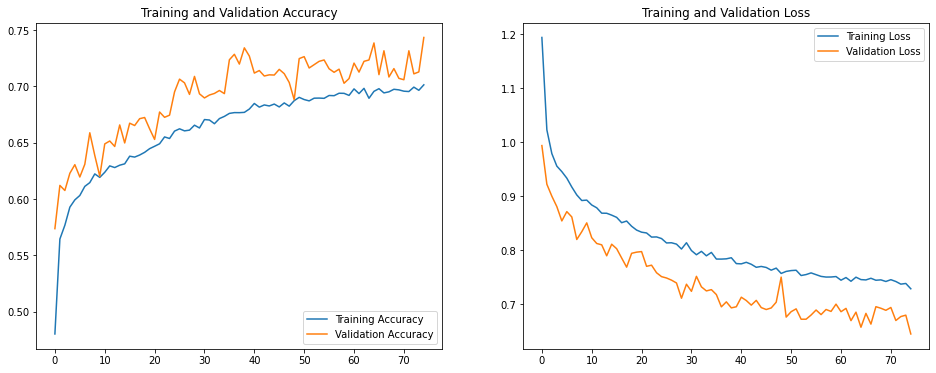

In [ ]:
train_model(tfio.experimental.color.rgb_to_xyz, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/75
360/360 [==============================] - 37s 77ms/step - loss: 1.6198 - accuracy: 0.2810 - val_loss: 1.4109 - val_accuracy: 0.3682
Epoch 2/75
360/360 [==============================] - 27s 74ms/step - loss: 1.4341 - accuracy: 0.3025 - val_loss: 1.4092 - val_accuracy: 0.3975
Epoch 3/75
360/360 [==============================] - 27s 74ms/step - loss: 1.4148 - accuracy: 0.3106 - val_loss: 1.3804 - val_accuracy: 0.3067
Epoch 4/75
360/360 [==============================] - 27s 74ms/step - loss: 1.3937 - accuracy: 0.3290 - val_loss: 1.3470 - val_accuracy: 0.3770
Epoch 5/75
360/360 [==============================] - 27s 74ms/step - loss: 1.3756 - accuracy: 0.3447 - val_loss: 1.3335 - val_accuracy: 0.4007
Epoch 6/75
360/360 [==============================] - 27s 74ms/step - loss: 1.3608 -

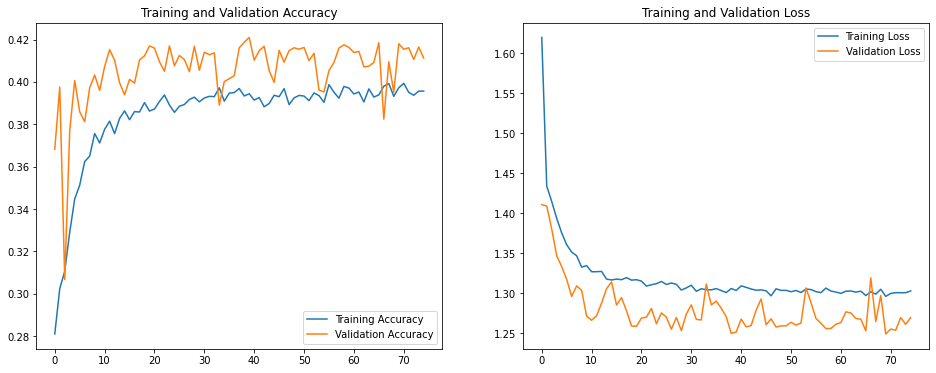

In [ ]:
train_model(tfio.experimental.color.rgb_to_hsv, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/75
360/360 [==============================] - 36s 76ms/step - loss: 0.9368 - accuracy: 0.5937 - val_loss: 0.7895 - val_accuracy: 0.6518
Epoch 2/75
360/360 [==============================] - 27s 74ms/step - loss: 0.8253 - accuracy: 0.6461 - val_loss: 0.7961 - val_accuracy: 0.6412
Epoch 3/75
360/360 [==============================] - 27s 75ms/step - loss: 0.8002 - accuracy: 0.6527 - val_loss: 0.7486 - val_accuracy: 0.6718
Epoch 4/75
360/360 [==============================] - 27s 74ms/step - loss: 0.7840 - accuracy: 0.6591 - val_loss: 0.7355 - val_accuracy: 0.6759
Epoch 5/75
360/360 [==============================] - 27s 74ms/step - loss: 0.7698 - accuracy: 0.6659 - val_loss: 0.7265 - val_accuracy: 0.6801
Epoch 6/75
360/360 [==============================] - 27s 74ms/step - loss: 0.7635 - accuracy: 0.6717 - 

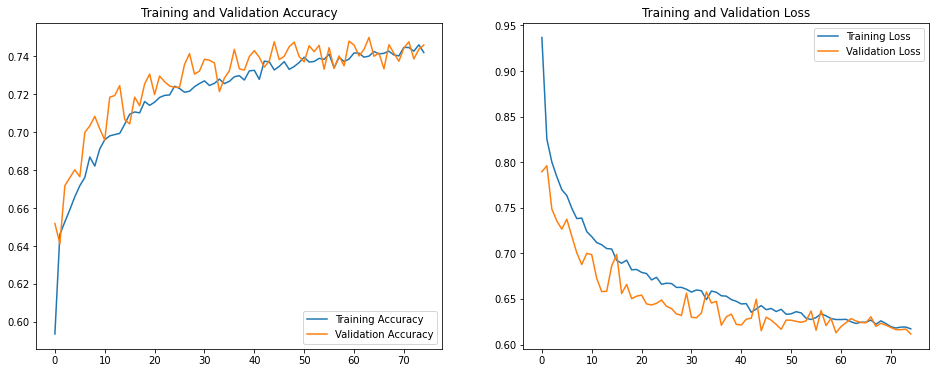

In [ ]:
train_model(tfio.experimental.color.rgb_to_hsv, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/75
360/360 [==============================] - 37s 78ms/step - loss: 1.6869 - accuracy: 0.2772 - val_loss: 1.4306 - val_accuracy: 0.2860
Epoch 2/75
360/360 [==============================] - 27s 76ms/step - loss: 1.4482 - accuracy: 0.2818 - val_loss: 1.4308 - val_accuracy: 0.2860
Epoch 3/75
360/360 [==============================] - 27s 76ms/step - loss: 1.4382 - accuracy: 0.2890 - val_loss: 1.4209 - val_accuracy: 0.2860
Epoch 4/75
360/360 [==============================] - 27s 76ms/step - loss: 1.4313 - accuracy: 0.2841 - val_loss: 1.4226 - val_accuracy: 0.2860
Epoch 5/75
360/360 [==============================] - 27s 76ms/step - loss: 1.4286 - accuracy: 0.2824 - val_loss: 1.4178 - val_accuracy: 0.2860
Epoch 6/75
360/360 [==============================] - 27s 76ms/step - loss: 1.4272 -

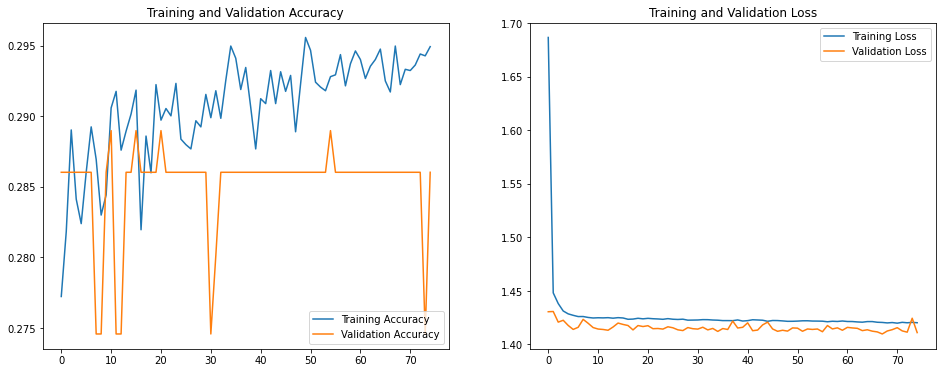

In [ ]:
train_model(tfio.experimental.color.rgb_to_yuv, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/75
360/360 [==============================] - 36s 76ms/step - loss: 1.1868 - accuracy: 0.4656 - val_loss: 0.9299 - val_accuracy: 0.5821
Epoch 2/75
360/360 [==============================] - 27s 75ms/step - loss: 0.9752 - accuracy: 0.5731 - val_loss: 0.8683 - val_accuracy: 0.6191
Epoch 3/75
360/360 [==============================] - 27s 75ms/step - loss: 0.9270 - accuracy: 0.5984 - val_loss: 0.8448 - val_accuracy: 0.6304
Epoch 4/75
360/360 [==============================] - 27s 75ms/step - loss: 0.8995 - accuracy: 0.6092 - val_loss: 0.8326 - val_accuracy: 0.6424
Epoch 5/75
360/360 [==============================] - 27s 75ms/step - loss: 0.8743 - accuracy: 0.6247 - val_loss: 0.8093 - val_accuracy: 0.6483
Epoch 6/75
360/360 [==============================] - 27s 75ms/step - loss: 0.8631 - accuracy: 0.6292 - 

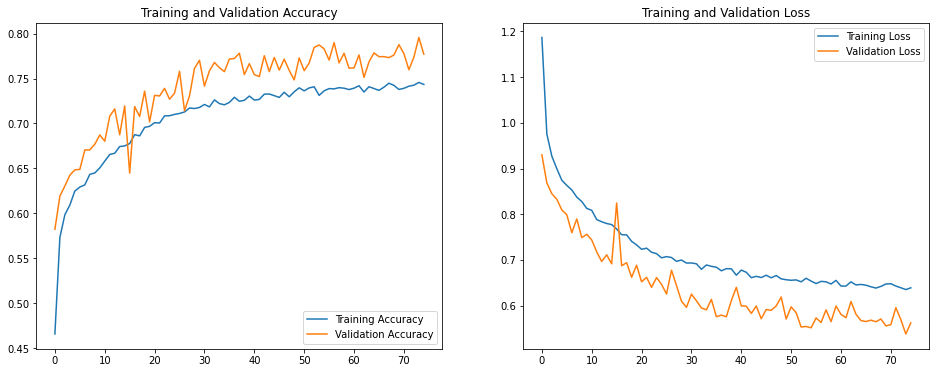

In [ ]:
train_model(tfio.experimental.color.rgb_to_yuv, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/75
360/360 [==============================] - 36s 77ms/step - loss: 1.6373 - accuracy: 0.2732 - val_loss: 1.4241 - val_accuracy: 0.2746
Epoch 2/75
360/360 [==============================] - 27s 75ms/step - loss: 1.4347 - accuracy: 0.2810 - val_loss: 1.4191 - val_accuracy: 0.2890
Epoch 3/75
360/360 [==============================] - 27s 75ms/step - loss: 1.4269 - accuracy: 0.2906 - val_loss: 1.4181 - val_accuracy: 0.2860
Epoch 4/75
360/360 [==============================] - 27s 75ms/step - loss: 1.4248 - accuracy: 0.2933 - val_loss: 1.4259 - val_accuracy: 0.2860
Epoch 5/75
360/360 [==============================] - 27s 75ms/step - loss: 1.4245 - accuracy: 0.2911 - val_loss: 1.4190 - val_accuracy: 0.2860
Epoch 6/75
360/360 [==============================] - 27s 75ms/step - loss: 1.4241 -

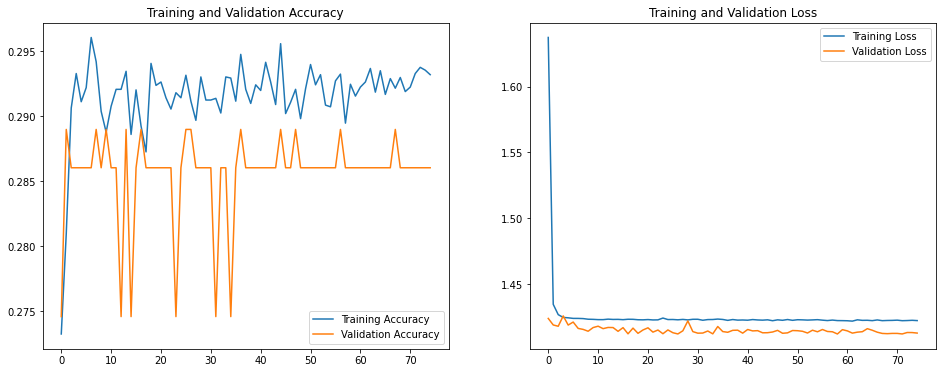

In [ ]:
train_model(tfio.experimental.color.rgb_to_ydbdr, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/75
360/360 [==============================] - 37s 77ms/step - loss: 1.1391 - accuracy: 0.4887 - val_loss: 0.9100 - val_accuracy: 0.5959
Epoch 2/75
360/360 [==============================] - 27s 75ms/step - loss: 0.9719 - accuracy: 0.5781 - val_loss: 0.8950 - val_accuracy: 0.6157
Epoch 3/75
360/360 [==============================] - 27s 75ms/step - loss: 0.9229 - accuracy: 0.6002 - val_loss: 0.8883 - val_accuracy: 0.6125
Epoch 4/75
360/360 [==============================] - 27s 75ms/step - loss: 0.9005 - accuracy: 0.6109 - val_loss: 0.8065 - val_accuracy: 0.6480
Epoch 5/75
360/360 [==============================] - 27s 75ms/step - loss: 0.8827 - accuracy: 0.6173 - val_loss: 0.8260 - val_accuracy: 0.6360
Epoch 6/75
360/360 [==============================] - 27s 75ms/step - loss: 0.8683 - accuracy: 0.6238 - 

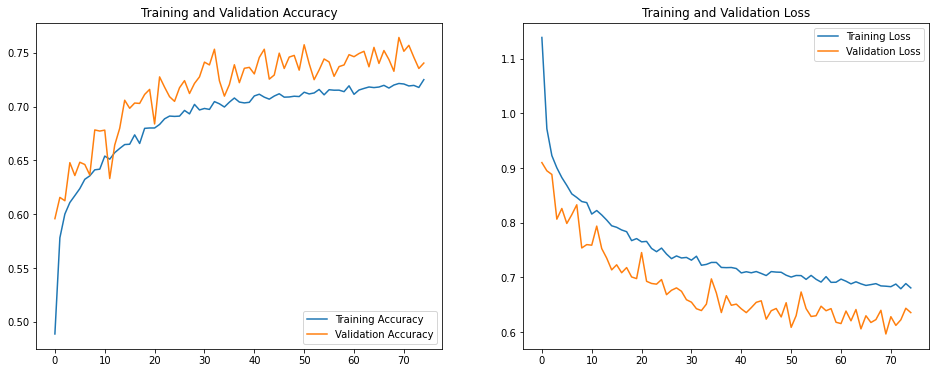

In [ ]:
train_model(tfio.experimental.color.rgb_to_ydbdr, preprocess=False)